In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import set_random_seed

In [2]:
set_random_seed(812)

In [3]:
# Download historical data (e.g., Apple)
df = yf.download('BBCA.JK', start='2015-05-15', end='2025-05-15')

# Use 'Close' price for prediction
data = df['Close'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])
        y.append(data[i])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# [samples, time_steps, features]
X = X.reshape((len(X), time_step, 1))

In [5]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [6]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(128),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


c:\Users\Gahtan Syarif Nahdi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,441 (1.76 MB)

 Trainable params: 461,441 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0153 - val_loss: 5.2274e-04
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 3.2116e-04 - val_loss: 5.1371e-04
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 2.6948e-04 - val_loss: 6.3965e-04
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 2.7538e-04 - val_loss: 4.8594e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 2.7808e-04 - val_loss: 4.4494e-04
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 2.5574e-04 - val_loss: 4.6224e-04
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 2.4401e-04 - val_loss: 4.8212e-04
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 2.3927e-04 - val_loss: 4.5542e-04
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 2.3890e-04 - val_loss: 4.1186e-04
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 2.3873e-04 - val_loss: 3.8313e-04
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 2.3601e-04 

In [8]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [9]:
mse = mean_squared_error(y_test_actual, predictions)
print("RMSE (rupiah):", np.sqrt(mse))

RMSE (rupiah): 157.65293755790466


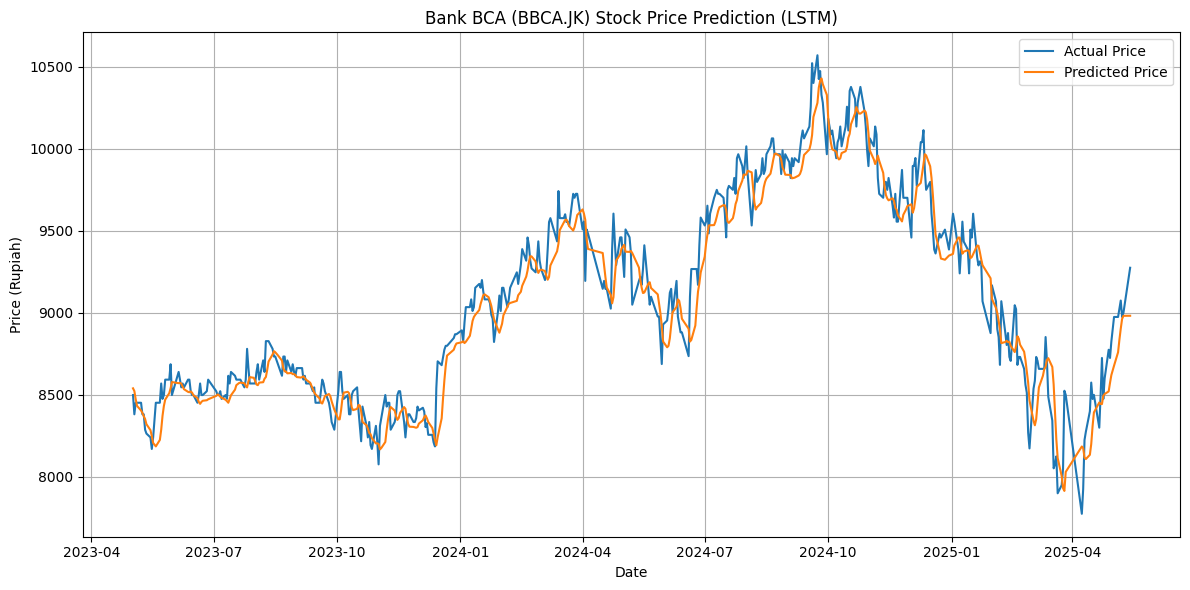

In [10]:
test_start_idx = len(X_train) + time_step
date_range = df.index[test_start_idx:test_start_idx + len(y_test)]
plt.figure(figsize=(12,6))
plt.plot(date_range, y_test_actual, label='Actual Price')
plt.plot(date_range, predictions, label='Predicted Price')
plt.title('Bank BCA (BBCA.JK) Stock Price Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('Price (Rupiah)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
